In [4]:
import  networkx as nx

In [5]:
G = nx.DiGraph()

In [6]:
n = 10
parents = [1, 1, 3, 3, 4, 4, 5, 5, 5]

In [7]:
edges = []

In [8]:
for i,j in zip(parents,range(2,10+1)):
    edges.append((i,j))

In [9]:
edges

[(1, 2), (1, 3), (3, 4), (3, 5), (4, 6), (4, 7), (5, 8), (5, 9), (5, 10)]

In [10]:
# initialize root
G.add_node(1)

In [11]:
# add parents
G.add_edges_from(edges)

In [12]:
G.edges

OutEdgeView([(1, 2), (1, 3), (3, 4), (3, 5), (4, 6), (4, 7), (5, 8), (5, 9), (5, 10)])

In [10]:
import matplotlib.pyplot as plt

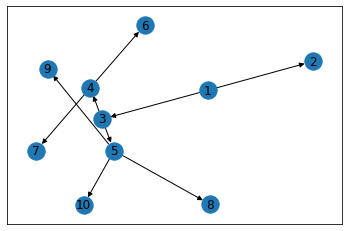

In [11]:
nx.draw_networkx(G)

In [12]:
%%time
# Lowest Common Ancestor
nx.algorithms.lowest_common_ancestor(G, 2, 5)

CPU times: user 590 ms, sys: 20.2 ms, total: 611 ms
Wall time: 609 ms


1

In [13]:
%%time
# Lowest Common Ancestor
nx.algorithms.all_pairs_lowest_common_ancestor(G, pairs=[(2, 5)])

CPU times: user 1.97 ms, sys: 230 µs, total: 2.2 ms
Wall time: 2.11 ms


<generator object all_pairs_lowest_common_ancestor.<locals>._compute_dag_lca_from_tree_values at 0xb57ac170>

In [18]:
%%time
# Lowest Common Ancestor
lca = nx.tree_all_pairs_lowest_common_ancestor(G, root=1, pairs=[(2,5), (2,3)])

CPU times: user 41 µs, sys: 5 µs, total: 46 µs
Wall time: 61.3 µs


In [16]:
"""Algorithms for finding the lowest common ancestor of trees and DAGs."""
from collections import defaultdict
from collections.abc import Mapping, Set
from itertools import chain, count

import networkx as nx
from networkx.utils import (
    arbitrary_element,
    not_implemented_for,
    UnionFind,
    generate_unique_node,
)

__all__ = [
    "all_pairs_lowest_common_ancestor",
    "tree_all_pairs_lowest_common_ancestor",
    "lowest_common_ancestor",
]


#[docs]@not_implemented_for("undirected")
#@not_implemented_for("multigraph")
def tree_all_pairs_lowest_common_ancestor(G, root=None, pairs=None):
    r"""Yield the lowest common ancestor for sets of pairs in a tree.

    Parameters
    ----------
    G : NetworkX directed graph (must be a tree)

    root : node, optional (default: None)
        The root of the subtree to operate on.
        If None, assume the entire graph has exactly one source and use that.

    pairs : iterable or iterator of pairs of nodes, optional (default: None)
        The pairs of interest. If None, Defaults to all pairs of nodes
        under `root` that have a lowest common ancestor.

    Returns
    -------
    lcas : generator of tuples `((u, v), lca)` where `u` and `v` are nodes
        in `pairs` and `lca` is their lowest common ancestor.

    Notes
    -----
    Only defined on non-null trees represented with directed edges from
    parents to children. Uses Tarjan's off-line lowest-common-ancestors
    algorithm. Runs in time $O(4 \times (V + E + P))$ time, where 4 is the largest
    value of the inverse Ackermann function likely to ever come up in actual
    use, and $P$ is the number of pairs requested (or $V^2$ if all are needed).

    Tarjan, R. E. (1979), "Applications of path compression on balanced trees",
    Journal of the ACM 26 (4): 690-715, doi:10.1145/322154.322161.

    See Also
    --------
    all_pairs_lowest_common_ancestor (similar routine for general DAGs)
    lowest_common_ancestor           (just a single pair for general DAGs)
    """
    if len(G) == 0:
        raise nx.NetworkXPointlessConcept("LCA meaningless on null graphs.")
    elif None in G:
        raise nx.NetworkXError("None is not a valid node.")

    # Index pairs of interest for efficient lookup from either side.
    if pairs is not None:
        pair_dict = defaultdict(set)
        # See note on all_pairs_lowest_common_ancestor.
        if not isinstance(pairs, (Mapping, Set)):
            pairs = set(pairs)
        for u, v in pairs:
            for n in (u, v):
                if n not in G:
                    msg = f"The node {str(n)} is not in the digraph."
                    raise nx.NodeNotFound(msg)
            pair_dict[u].add(v)
            pair_dict[v].add(u)

    # If root is not specified, find the exactly one node with in degree 0 and
    # use it. Raise an error if none are found, or more than one is. Also check
    # for any nodes with in degree larger than 1, which would imply G is not a
    # tree.
    if root is None:
        for n, deg in G.in_degree:
            if deg == 0:
                if root is not None:
                    msg = "No root specified and tree has multiple sources."
                    raise nx.NetworkXError(msg)
                root = n
            elif deg > 1:
                msg = "Tree LCA only defined on trees; use DAG routine."
                raise nx.NetworkXError(msg)
    if root is None:
        raise nx.NetworkXError("Graph contains a cycle.")

    # Iterative implementation of Tarjan's offline lca algorithm
    # as described in CLRS on page 521 (2nd edition)/page 584 (3rd edition)
    uf = UnionFind()
    ancestors = {}
    for node in G:
        ancestors[node] = uf[node]

    colors = defaultdict(bool)
    for node in nx.dfs_postorder_nodes(G, root):
        colors[node] = True
        for v in pair_dict[node] if pairs is not None else G:
            if colors[v]:
                # If the user requested both directions of a pair, give it.
                # Otherwise, just give one.
                if pairs is not None and (node, v) in pairs:
                    yield ancestors[uf[v]]
                if pairs is None or (v, node) in pairs:
                    yield ancestors[uf[v]]
        if node != root:
            parent = arbitrary_element(G.pred[node])
            uf.union(parent, node)
            ancestors[uf[parent]] = parent

In [17]:
lca = tree_all_pairs_lowest_common_ancestor(G, root=1, pairs=[(2,5), (2,3)])

In [18]:
lca

<generator object tree_all_pairs_lowest_common_ancestor at 0xb3d63d30>

In [22]:
list(lca)

[1, 1]

In [17]:
%%time
sum(i[-1] for i in lca)

CPU times: user 442 µs, sys: 53 µs, total: 495 µs
Wall time: 518 µs


2

In [19]:
%%time
sum([i[-1] for i in lca])

CPU times: user 492 µs, sys: 61 µs, total: 553 µs
Wall time: 580 µs


2

In [61]:
import itertools

In [65]:
next(itertools.islice(lca,1))

StopIteration: 

In [66]:
nx.algorithms.is_tree(G)

True

In [71]:
lca is None

False